# Análisis de Ventas / Inventarios

Preparación del entorno

In [1]:
# Bibliotecas para manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# Evaluación de modelos
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from math import sqrt


In [3]:
# Configuración global para visualizaciones
plt.style.use('default')
sns.set_theme(style="whitegrid")

# Cargar las tablas
data_ventas = pd.read_csv('Ventas.csv')
data_inventario_inicial = pd.read_csv('InventarioInicial.csv')
data_inventario_final = pd.read_csv('InventarioFinal.csv')

# Resumen de las tablas cargadas
print("Ventas:", data_ventas.shape)
print("Inventario Inicial:", data_inventario_inicial.shape)
print("Inventario Final:", data_inventario_final.shape)


Ventas: (1027938, 13)
Inventario Inicial: (206527, 10)
Inventario Final: (224489, 10)


Limpieza de datos

In [18]:

# Verificar valores nulos
print("Valores nulos en Ventas:")
print(data_ventas.isnull().sum())

print("\nValores nulos en Inventario Inicial:")
print(data_inventario_inicial.isnull().sum())

print("\nValores nulos en Inventario Final:")
print(data_inventario_final.isnull().sum())

# Rellenar valores nulos o eliminarlos según corresponda
data_ventas.fillna(0, inplace=True)
data_inventario_inicial.fillna(0, inplace=True)
data_inventario_final.fillna(0, inplace=True)


Valores nulos en Ventas:
InventoryId      0
Store            0
Brand            0
Description      0
SalesQuantity    0
SalesDollars     0
SalesPrice       0
SalesDate        0
ExciseTax        0
VendorNumber     0
size_ml          0
pack_count       0
SalesID          0
dtype: int64

Valores nulos en Inventario Inicial:
InventoryId    0
Store          0
City           0
Brand          0
Description    0
onHand         0
Price          0
startDate      0
size_ml        0
pack_count     0
dtype: int64

Valores nulos en Inventario Final:
InventoryId    0
Store          0
City           0
Brand          0
Description    0
onHand         0
Price          0
endDate        0
size_ml        0
pack_count     0
dtype: int64


In [9]:
# Eliminar filas con valores nulos
data_inventario_final.dropna(subset=['size_ml', 'pack_count'], inplace=True)

# Verificar el resultado
print(data_inventario_final.isnull().sum())


InventoryId    0
Store          0
City           0
Brand          0
Description    0
onHand         0
Price          0
endDate        0
size_ml        0
pack_count     0
dtype: int64


quizas puedo hacer un mapa con las ciudades, traigo onhand de inventarios tambien (estoy trayendo city de ahi) aunque no se si analizar onhand porque esta lleno de incongruencias. podria generar un onhand de la tabla de compras? y que sea como que se va almacenando en el inventario? acabo de darme cuenta que onhand final no tendria sentido aqui porque en ventas solo tengo datos hasta fines de febrero asique aunque encuentre una manera de traer las compras e ir almacenando en el inventario, solo tengo datos de 2 meses

uno inventario inicial y final con onhand en ciudades_inventario

In [47]:
# Combinar Inventario Inicial y Final para obtener todas las ciudades únicas por InventoryId
inventario_inicial = data_inventario_inicial.rename(columns={'onHand': 'onHand_Inicial'})
inventario_final = data_inventario_final.rename(columns={'onHand': 'onHand_Final'})

# Combinar Inventario Inicial y Final para mantener las ciudades
ciudades_inventario = pd.merge(
    inventario_inicial[['InventoryId', 'City', 'onHand_Inicial']],
    inventario_final[['InventoryId', 'City', 'onHand_Final']],
    on=['InventoryId', 'City'],  # Usar InventoryId y City como claves
    how='outer'  # Mantener datos de ambos inventarios
)

# Realizar el join con la tabla de ventas para traer las ciudades
ventas_con_ciudades = pd.merge(data_ventas, ciudades_inventario[['InventoryId', 'City']], on='InventoryId', how='left')

# Verificar si 'City' está presente ahora
if 'City' in ventas_con_ciudades.columns:
    print("Columna 'City' incorporada exitosamente.")
else:
    print("Error: No se pudo incorporar la columna 'City'.")
ventas_con_ciudades.head()

Columna 'City' incorporada exitosamente.


,InventoryId,Store,Brand,Description,SalesQuantity,SalesDollars,SalesPrice,SalesDate,ExciseTax,VendorNumber,...,pack_count_Winsorized,ExciseTax_Winsor,SalesPrice_Winsor,size_ml_Winsor,pack_count_Winsor,ExciseTax_to_SalesPrice,size_per_pack,Revenue_per_size,Predicted_Sales,City
0,38_goulcrest_8823,38,8823,Leroux Apricot Brandy,1,7.99,7.99,2016-01-12,0.79,12546,...,1.0,0.79,7.99,750.0,1.0,0.098874,750.0,0.010653,1.0,goulcrest
1,38_goulcrest_8823,38,8823,Leroux Apricot Brandy,1,7.99,7.99,2016-01-14,0.79,12546,...,1.0,0.79,7.99,750.0,1.0,0.098874,750.0,0.010653,1.0,goulcrest
2,38_goulcrest_8823,38,8823,Leroux Apricot Brandy,3,23.97,7.99,2016-01-22,2.36,12546,...,1.0,2.36,7.99,750.0,1.0,0.295369,750.0,0.031960,3.0,goulcrest
3,38_goulcrest_8823,38,8823,Leroux Apricot Brandy,2,15.98,7.99,2016-01-24,1.57,12546,...,1.0,1.57,7.99,750.0,1.0,0.196496,750.0,0.021307,2.0,goulcrest
4,38_goulcrest_8823,38,8823,Leroux Apricot Brandy,1,7.99,7.99,2016-01-25,0.79,12546,...,1.0,0.79,7.99,750.0,1.0,0.098874,750.0,0.010653,1.0,goulcrest


In [11]:
ventas_con_ciudades.head()
ventas_con_ciudades.shape

(1027938, 14)

In [12]:

# Filtrar las ciudades únicas
ciudades_unicas = ventas_con_ciudades['City'].dropna().unique()

# Crear un DataFrame con las ciudades únicas
ciudades_df = pd.DataFrame(ciudades_unicas, columns=['City'])

# Guardar las ciudades en un archivo CSV
ciudades_df.to_csv('ciudades_unicas.csv', index=False, encoding='utf-8')

print(f"Se han guardado {len(ciudades_df)} ciudades únicas en el archivo 'ciudades_unicas.csv'.")


Se han guardado 67 ciudades únicas en el archivo 'ciudades_unicas.csv'.


In [13]:

# Cargar el archivo de ciudades
ciudades = pd.read_csv('ciudades_unicas.csv')

# Convertir a minúsculas para facilitar la comparación
ciudades['City_lower'] = ciudades['City'].str.lower()

# Palabras sospechosas o sin sentido
palabras_sospechosas = ['unknown', 'unknwon', 'uknown', 'null', 'none', 'nan']

# Buscar coincidencias exactas con palabras sospechosas
ciudades_invalidas = ciudades[ciudades['City_lower'].isin(palabras_sospechosas)]

# Buscar valores con caracteres sospechosos (números, caracteres especiales, etc.)
ciudades_invalidas = pd.concat([
    ciudades_invalidas,
    ciudades[ciudades['City_lower'].str.contains(r'[^a-z\s\-]', na=False)]  # Filtra si contiene algo que no sea letras, espacios o guiones
])

# Eliminar duplicados si aparecen en ambas condiciones
ciudades_invalidas = ciudades_invalidas.drop_duplicates()

# Mostrar las ciudades sospechosas
print("Ciudades sospechosas o inválidas:")
print(ciudades_invalidas)

# Guardar el resultado en un archivo si es necesario
ciudades_invalidas.to_csv('ciudades_invalidas.csv', index=False)


Ciudades sospechosas o inválidas:
             City     City_lower
10   pella's wish   pella's wish
20  beggar's hole  beggar's hole
60   knife's edge   knife's edge


In [15]:
# Convertir todas las ciudades en el DataFrame a minúsculas
ventas_con_ciudades['City'] = ventas_con_ciudades['City'].str.lower()

# Lista de nombres de ciudades sospechosas (también en minúsculas)
ciudades_sospechosas = ["pella's wish", "beggar's hole", "knife's edge"]

# Contar cuántas veces aparece cada ciudad en el DataFrame
conteo_ciudades = ventas_con_ciudades[ventas_con_ciudades['City'].isin(ciudades_sospechosas)]['City'].value_counts()

# Mostrar los resultados
print("Conteo de ciudades sospechosas en ventas_con_ciudades:")
print(conteo_ciudades)

# Opcional: Guardar el conteo en un archivo CSV
conteo_ciudades.to_csv('conteo_ciudades_sospechosas.csv', index=True)


Conteo de ciudades sospechosas en ventas_con_ciudades:
City
beggar's hole    10404
pella's wish      7648
knife's edge      1774
Name: count, dtype: int64


afff esas ciudades ni existen... quizas podriamos  reemplazar todas las ciudades por ciudades que conozcamos pero obvio la distribucion de las ciudades va a ser cualquier cosa. 

TOP 10 STORES CON MAYOR VENTA

C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_9516\104618336.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_stores, x='Store_City', y='SalesQuantity', palette='viridis')


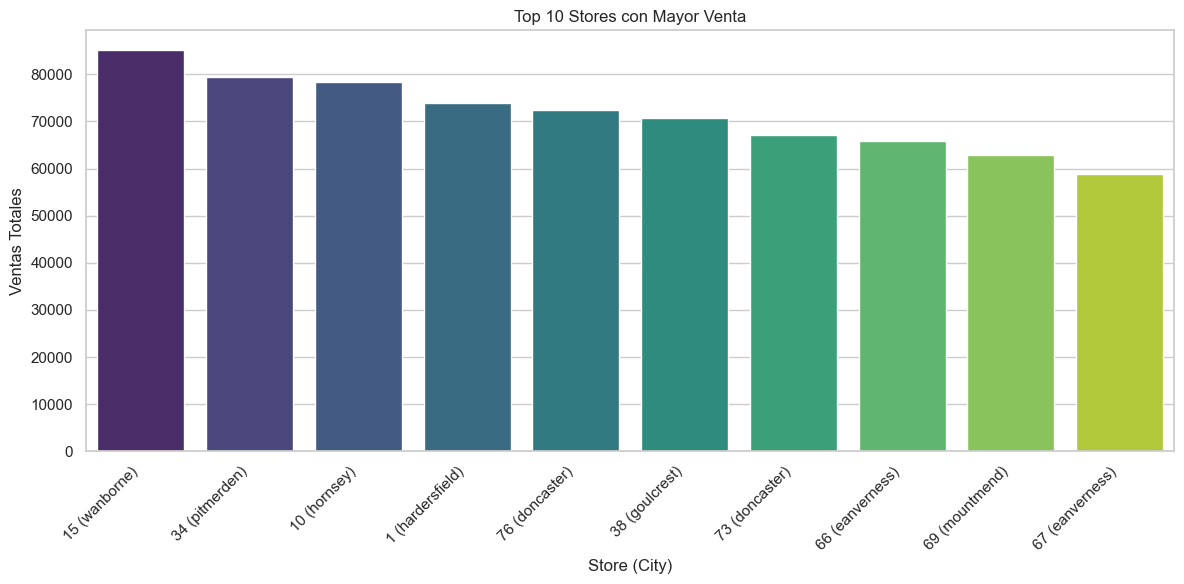

In [17]:
# Agrupar por Store para calcular las ventas totales
ventas_por_store = ventas_con_ciudades.groupby('Store').agg({
    'SalesQuantity': 'sum',  # Sumar las cantidades vendidas
    'City': 'first'          # Seleccionar la ciudad correspondiente
}).reset_index()

# Ordenar las tiendas por ventas totales en orden descendente
ventas_por_store = ventas_por_store.sort_values('SalesQuantity', ascending=False)

# Crear una columna combinada con Store y City para el gráfico
top_10_stores['Store_City'] = top_10_stores['Store'].astype(str) + " (" + top_10_stores['City'] + ")"

# Visualizar las tiendas y ciudades más relevantes
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_stores, x='Store_City', y='SalesQuantity', palette='viridis')
plt.title('Top 10 Stores con Mayor Venta')
plt.xlabel('Store (City)')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Hornsey y Doncaster se encuentran en Inglaterra. Las otras ciudades—Wanborne, Pitmerden, Hardersfield, Goulcrest, Eanverness y Mountmend—no corresponden a localidades reconocidas en registros geográficos oficiales. Es posible que estos nombres sean ficticios, errores tipográficos o referencias internas específicas de tu organización o proyecto. 

Random Forest: comence con las variables sin tratar los outliers pero al final los trate. A brand lo termine categorizando segun el precio porque tiene mas sentido que por quantity y de todas maneras con quantity no me daba ninguna correlacion. 

In [19]:
# Calcular el total de ventas por marca
ventas_por_marca = data_ventas.groupby('Brand')['SalesQuantity'].sum().reset_index()

# Crear categorías: top, medium, low
ventas_por_marca['BrandCategory'] = pd.qcut(ventas_por_marca['SalesQuantity'], q=3, labels=['Low', 'Medium', 'Top'])

# Asociar la categoría a la tabla original
data_ventas = data_ventas.merge(ventas_por_marca[['Brand', 'BrandCategory']], on='Brand', how='left')

# Convertir la categoría en variable numérica
data_ventas['BrandCategory_encoded'] = data_ventas['BrandCategory'].map({'Low': 0, 'Medium': 1, 'Top': 2})


Calcular ventas totales por marca:

Agrupamos las ventas por Brand para calcular la cantidad total vendida.
División en categorías:

Usamos pd.qcut() para dividir las marcas en 3 grupos:
Top: Las marcas más vendidas.
Medium: Marcas con ventas moderadas.
Low: Marcas con ventas bajas.
Mapeo de categorías a números:
NOPE, probe y me sale una correlacion de 0.07 con la cantidad que se vende asique las voy a dividir por precios
Convertimos las categorías (Low, Medium, Top) a valores numéricos (0, 1, 2) con map().
Preparación del modelo:

Usamos BrandCategory_encoded junto con otras características (SalesPrice, size_ml, etc.) como entrada del modelo.
Evaluación del modelo:

Calculamos RMSE y el R² para medir el desempeño.
Visualizamos las predicciones vs. valores reales.


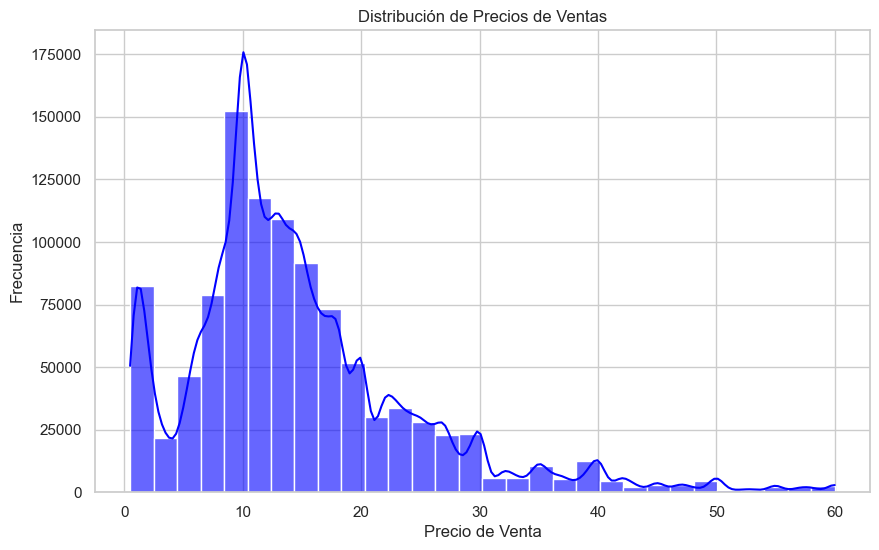

   Brand  SalesPrice BrandCategory  BrandCategory_encoded
0   8823        7.99           Low                      0
1   8823        7.99           Low                      0
2   8823        7.99           Low                      0
3   8823        7.99           Low                      0
4   8823        7.99           Low                      0


In [20]:
# Verificar distribución de precios por marca
plt.figure(figsize=(10, 6))
sns.histplot(data_ventas['SalesPrice'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Distribución de Precios de Ventas')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

# Calcular los percentiles (33% y 67%) para dividir en categorías
percentil_33 = data_ventas['SalesPrice'].quantile(0.33)
percentil_67 = data_ventas['SalesPrice'].quantile(0.67)

# Crear categorías basadas en los percentiles
def asignar_categoria(precio):
    if precio <= percentil_33:
        return 'Low'
    elif precio <= percentil_67:
        return 'Medium'
    else:
        return 'Top'

# Asignar categorías a las marcas
data_ventas['BrandCategory'] = data_ventas['SalesPrice'].apply(asignar_categoria)

# Codificar las categorías para el modelo
data_ventas['BrandCategory_encoded'] = data_ventas['BrandCategory'].map({'Low': 0, 'Medium': 1, 'Top': 2})

# Verificar resultados
print(data_ventas[['Brand', 'SalesPrice', 'BrandCategory', 'BrandCategory_encoded']].head())


RMSE (sklearn): 0.4493018000546401
R² Score: 0.9552594649964418
RMSE manual: 0.4493018000546401


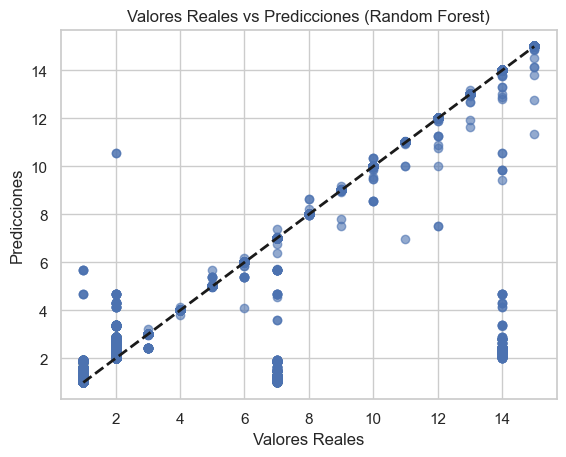

In [21]:
# Preparar las características para el modelo
features = ['SalesPrice', 'size_ml', 'pack_count', 'ExciseTax', 'BrandCategory_encoded']
target = 'SalesQuantity'

# Dividir las características y la variable objetivo
X = data_ventas[features]
y = data_ventas[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf_model.predict(X_test)

# Calcular RMSE usando sklearn
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE (sklearn): {rmse}")
print(f"R² Score: {r2}")

# Calcular RMSE manualmente
errors = y_test - y_pred  # Calcular los errores (diferencias)
squared_errors = errors ** 2  # Elevar al cuadrado los errores
mean_squared_error_manual = np.mean(squared_errors)  # Promediar los errores cuadrados
rmse_manual = np.sqrt(mean_squared_error_manual)  # Tomar la raíz cuadrada

print(f"RMSE manual: {rmse_manual}")

# Visualización de los resultados
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('Valores Reales vs Predicciones (Random Forest)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


                 Feature  Importance
3              ExciseTax    0.714582
1                size_ml    0.202530
0             SalesPrice    0.082310
2             pack_count    0.000367
4  BrandCategory_encoded    0.000212


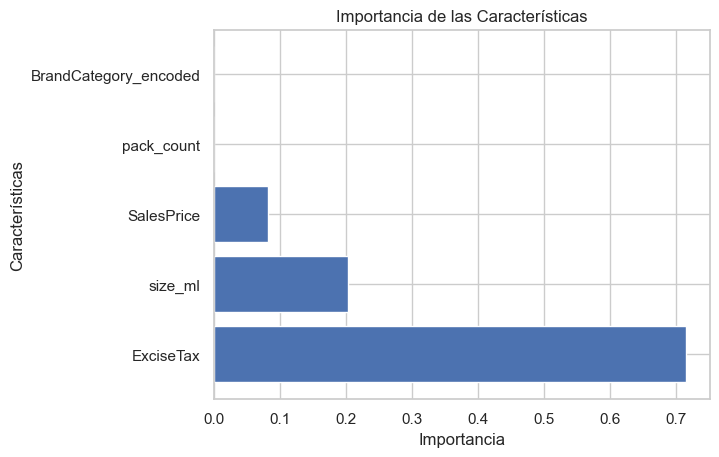

In [32]:
# Importancia de las características en el modelo Random Forest
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

# Gráfica de importancia
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()


Explora interacciones: Considera agregar nuevas variables que combinen las características actuales, como el precio final después de impuestos (SalesPrice + ExciseTax), para evaluar su impacto.

In [ ]:
#intente clasificar las marcas segun el volumen de menta pero no hay ninguna correlacion.
# Correlación entre la categoría numérica y las ventas
#data_ventas['BrandCategory_encoded'] = data_ventas['BrandCategory'].map({'Low': 0, 'Medium': 1, 'Top': 2})
#correlacion = data_ventas[['SalesQuantity', 'BrandCategory_encoded']].corr()
#print(correlacion)


                       SalesQuantity  BrandCategory_encoded
SalesQuantity               1.000000               0.075013
BrandCategory_encoded       0.075013               1.000000


oki no la uso

### **1. Robustez de Random Forest frente a outliers**
- **Ventaja:** Random Forest es un modelo robusto frente a los outliers porque utiliza la mediana en lugar de la media al calcular las predicciones agregadas en los árboles. Esto reduce el impacto de los valores extremos.
En teoria estamos asumiendo que los outliers son representativos de casos reales (productos premium, compras por volumen, etc.), entonces el modelo es adecuado, por eso no trato los outliers


### **2. Evaluación de la métrica (RMSE y R²)**
- **RMSE bajo y R² alto:** Según los resultados (RMSE de ~0.45 y R² > 0.95), el modelo está ajustándose bien a los datos. Esto sugiere que Random Forest está manejando los datos con outliers de manera efectiva.


**¿Está bien aplicado?**
Los resultados indican buen desempeño, pero deberías validar el modelo en un conjunto completamente nuevo (no usado en entrenamiento ni prueba) para confirmar que generaliza bien.

---

### **3. Importancia de las características**
- La gráfica muestra que **ExciseTax** domina el modelo, lo cual es razonable si los impuestos tienen un impacto directo en las ventas. Sin embargo, deberías asegurarte de que la variable sea consistente y no esté sesgada por valores extremos.

**¿Está bien aplicado?**
Es importante verificar si los datos tienen suficiente variabilidad para todas las características importantes. Por ejemplo:
  - Si el impuesto (ExciseTax) no varía mucho para diferentes productos, podría estar exagerando su importancia.
  - Las variables relacionadas con precios y tamaños deberían ser revisadas para garantizar que los outliers no dominen completamente su contribución al modelo.

---

### **4. Presencia de outliers**
Si los datos contienen muchos outliers, el modelo puede estar funcionando bien en términos de métricas, pero no necesariamente será útil para decisiones prácticas. Algunas consideraciones:
- **Identifica la naturaleza de los outliers:** 
  - ¿Son errores (p. ej., precios mal registrados, ventas inusualmente altas)? → Deberían eliminarse o ajustarse.
  - ¿Son eventos reales pero raros (p. ej., promociones especiales)? → Podrían tratarse como casos especiales, quizás mediante un modelo adicional.
- **Prueba una transformación de datos:** Algunas transformaciones (p. ej., logaritmo en precios o cantidades) pueden reducir el impacto de los outliers y ayudar al modelo.

**¿Está bien aplicado?**
Si los outliers son representativos de la realidad y no ruido, el modelo está bien aplicado. De lo contrario, los outliers podrían estar introduciendo sesgos.

---

### **5. Alternativas para validar**
Para validar si este modelo es adecuado con los datos actuales:
1. **Comparación con otros modelos:** 
   - Modelos como Gradient Boosting o XGBoost podrían manejar mejor los outliers y capturar interacciones complejas.
   - Linear Regression puede servir como una línea base para verificar si Random Forest realmente está aportando valor adicional.
   
2. **Validación cruzada:** Usa validación cruzada (k-fold cross-validation) para verificar que los buenos resultados no sean producto de particiones específicas en los datos.

3. **Ajustar hiperparámetros:** Realiza una búsqueda de hiperparámetros (GridSearchCV) para optimizar los parámetros de Random Forest y verificar si hay mejoras.

---

### **Conclusión**
El modelo **parece bien aplicado** porque:
- Random Forest es robusto frente a outliers.
- Las métricas (RMSE y R²) sugieren un buen ajuste.
  
Sin embargo:
1. Deberías verificar la naturaleza de los outliers para garantizar que representen patrones reales.
2. Valida el modelo en datos completamente nuevos.
3. Considera ajustar los hiperparámetros y explorar otros modelos para confirmar los resultados.

¿Quieres que exploremos alguna de estas áreas en más detalle?

mejorar modelo con hiperparametros

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
RMSE (Optimizado): 0.44965501404760816
R² Score (Optimizado): 0.9551890927224355


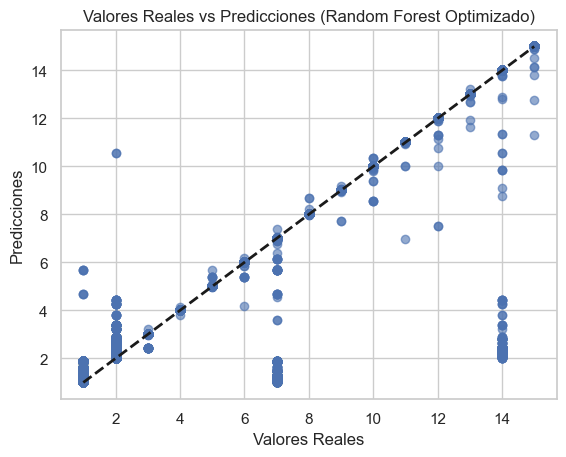

In [ ]:

# Definir los hiperparámetros y sus valores posibles
param_dist = {
    'n_estimators': [100, 200],       # Número de árboles
    'max_depth': [10, 20],           # Profundidad máxima
    'min_samples_split': [2, 5],     # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2],      # Mínimo número de muestras por hoja
    'max_features': ['sqrt', None]   # Número máximo de características a considerar
}

# Crear el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Configurar la búsqueda aleatoria con RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_dist, 
                                   n_iter=10,                   # Número de combinaciones a probar
                                   scoring='neg_mean_squared_error', 
                                   cv=3,                       # Validación cruzada con 3 particiones
                                   verbose=2,                  # Nivel de detalle en la salida
                                   n_jobs=-1,                  # Usar todos los núcleos disponibles
                                   random_state=42)            # Reproducibilidad

# Ajustar RandomizedSearchCV con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = random_search.best_params_
print("Mejores parámetros:", best_params)

# Usar el mejor modelo encontrado
best_rf_model = random_search.best_estimator_

# Evaluar el modelo optimizado en el conjunto de prueba
y_pred = best_rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE (Optimizado): {rmse}")
print(f"R² Score (Optimizado): {r2}")

# Visualizar resultados
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('Valores Reales vs Predicciones (Random Forest Optimizado)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


 **3. Importancia de las características**
- La gráfica muestra que **ExciseTax** domina el modelo, lo cual es razonable si los impuestos tienen un impacto directo en las ventas. Sin embargo, deberías asegurarte de que la variable sea consistente y no esté sesgada por valores extremos.

**¿Está bien aplicado?**
Es importante verificar si los datos tienen suficiente variabilidad para todas las características importantes. Por ejemplo:
  - Si el impuesto (ExciseTax) no varía mucho para diferentes productos, podría estar exagerando su importancia.
  - Las variables relacionadas con precios y tamaños deberían ser revisadas para garantizar que los outliers no dominen completamente su contribución al modelo.

count    1.027938e+06
mean     1.206902e+00
std      2.236172e+00
min      1.000000e-02
25%      1.600000e-01
50%      6.000000e-01
75%      1.570000e+00
max      2.756000e+01
Name: ExciseTax, dtype: float64


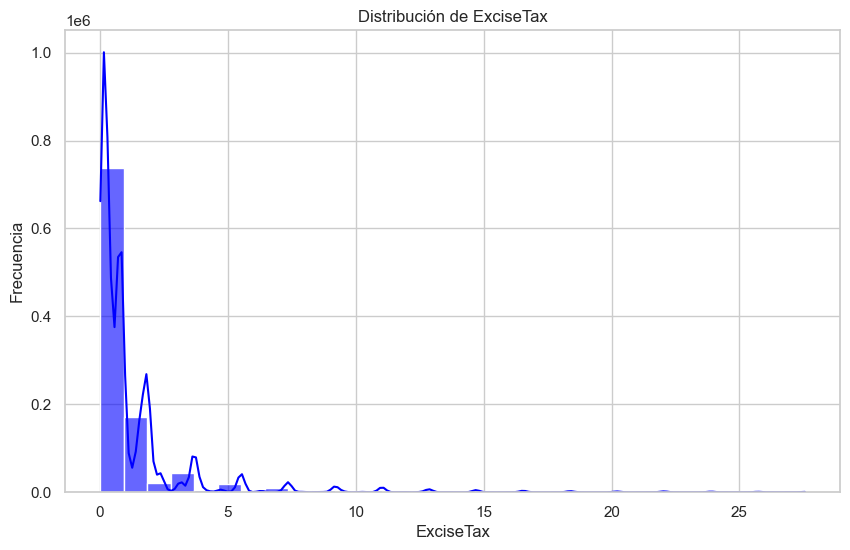

Valores atípicos de ExciseTax: 54675


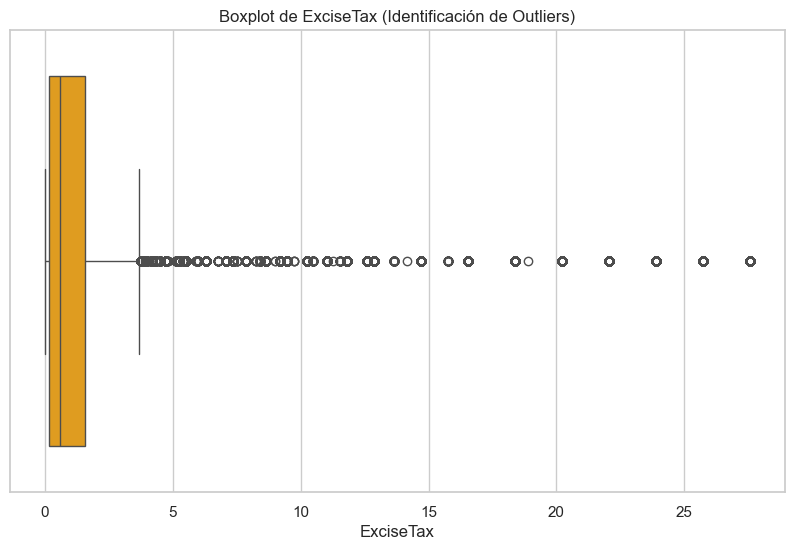

In [22]:
# Resumen estadístico de ExciseTax
print(data_ventas['ExciseTax'].describe())

# Visualización de la distribución de ExciseTax
plt.figure(figsize=(10, 6))
sns.histplot(data_ventas['ExciseTax'], bins=30, kde=True, color='blue', alpha=0.6)
plt.title('Distribución de ExciseTax')
plt.xlabel('ExciseTax')
plt.ylabel('Frecuencia')
plt.show()

# Identificar outliers utilizando el rango intercuartílico (IQR)
q1 = data_ventas['ExciseTax'].quantile(0.25)
q3 = data_ventas['ExciseTax'].quantile(0.75)
iqr = q3 - q1
outlier_threshold_low = q1 - 1.5 * iqr
outlier_threshold_high = q3 + 1.5 * iqr

# Contar valores atípicos
outliers = data_ventas[(data_ventas['ExciseTax'] < outlier_threshold_low) | 
                        (data_ventas['ExciseTax'] > outlier_threshold_high)]
print(f"Valores atípicos de ExciseTax: {len(outliers)}")

# Visualización de outliers con un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_ventas['ExciseTax'], color='orange')
plt.title('Boxplot de ExciseTax (Identificación de Outliers)')
plt.xlabel('ExciseTax')
plt.show()


          ExciseTax    SalesPrice       size_ml    pack_count
count  1.027938e+06  1.027938e+06  1.027938e+06  1.027938e+06
mean   1.206902e+00  1.477378e+01  9.512599e+02  1.023397e+00
std    2.236172e+00  9.816412e+00  7.109163e+02  2.710315e-01
min    1.000000e-02  4.900000e-01  5.000000e+01  1.000000e+00
25%    1.600000e-01  8.990000e+00  7.500000e+02  1.000000e+00
50%    6.000000e-01  1.299000e+01  7.500000e+02  1.000000e+00
75%    1.570000e+00  1.799000e+01  1.500000e+03  1.000000e+00
max    2.756000e+01  5.999000e+01  5.000000e+03  1.200000e+01


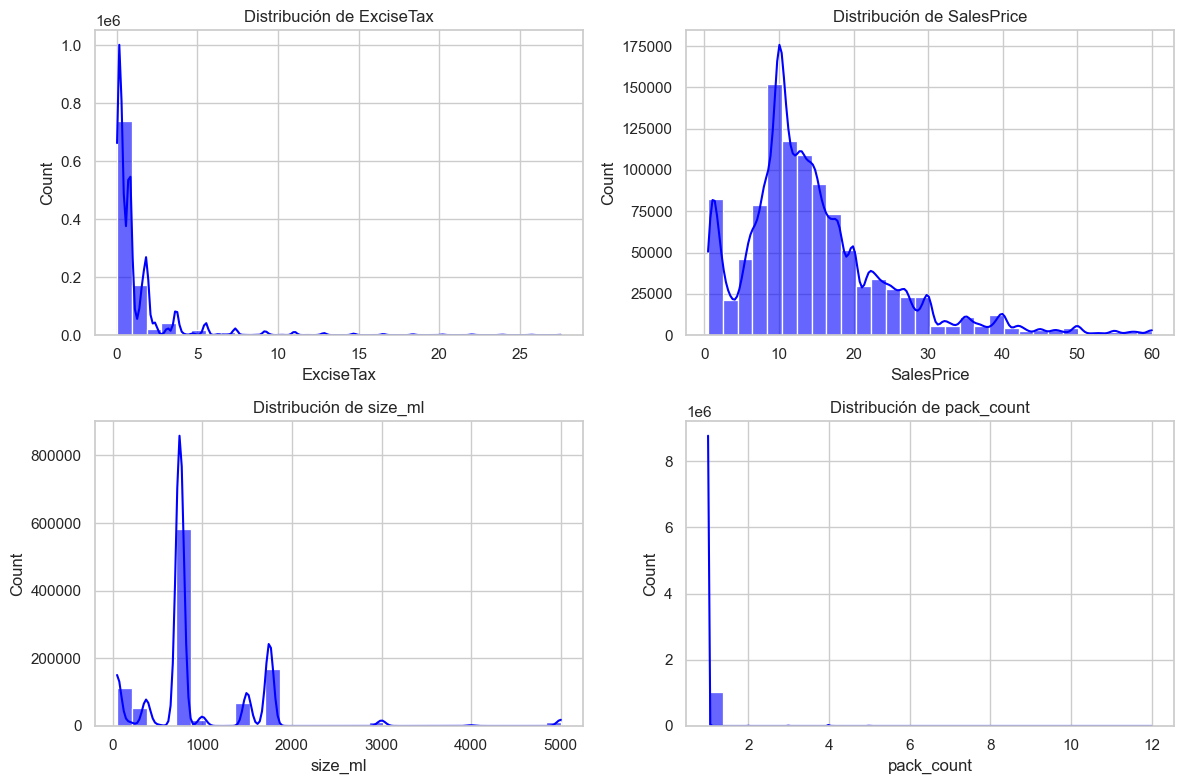

<Figure size 1000x600 with 0 Axes>

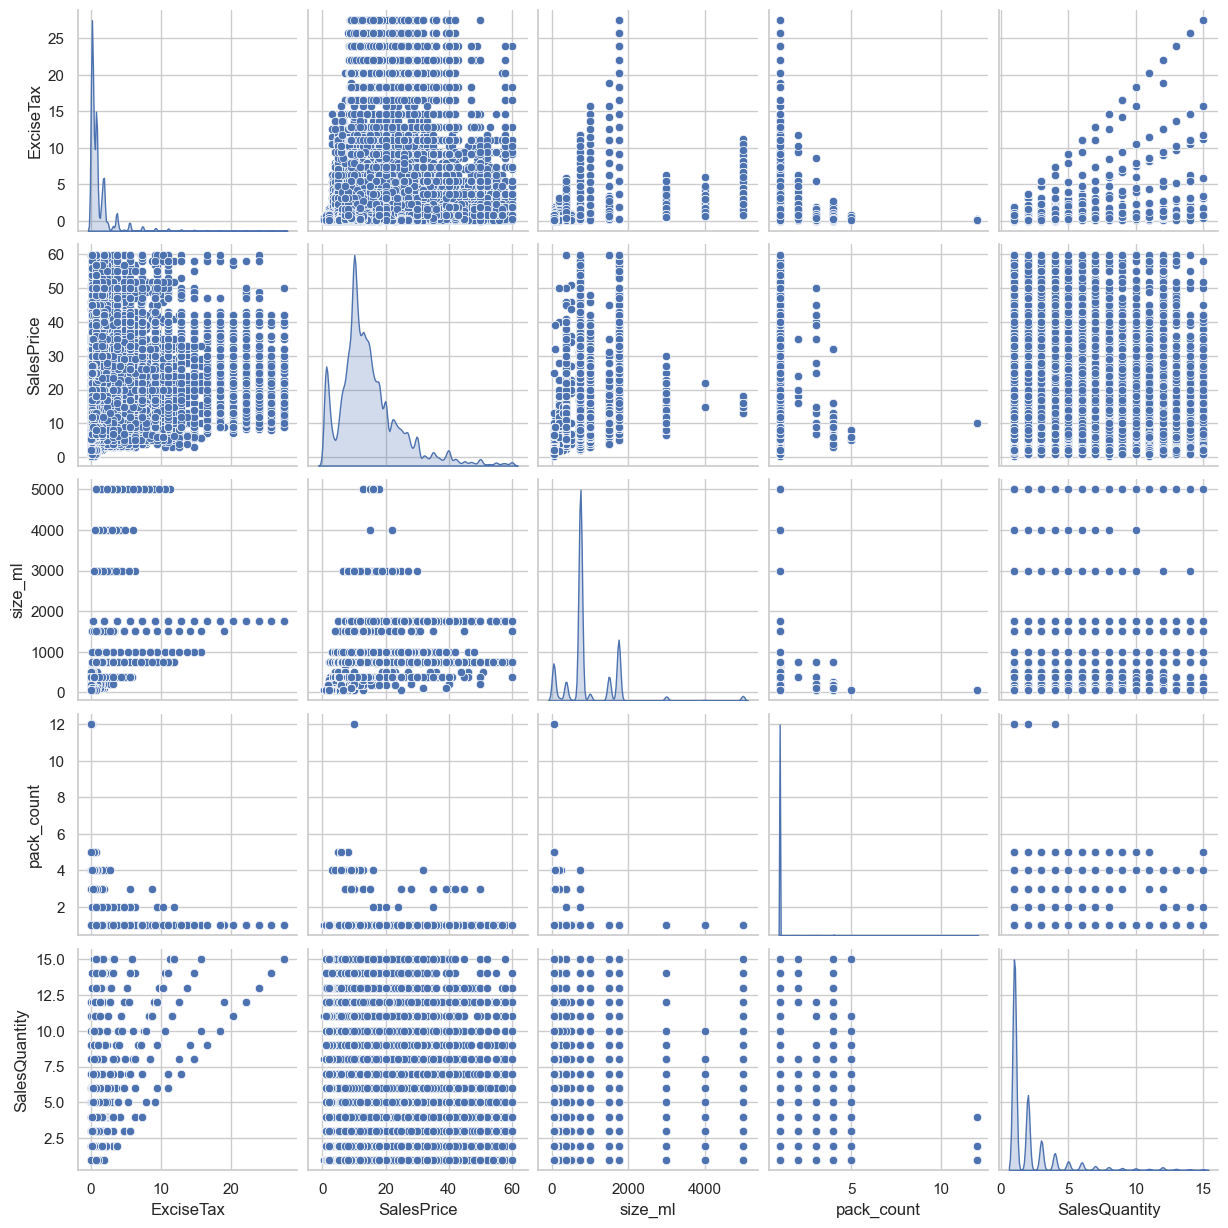

In [23]:
# Resumen estadístico de todas las características relevantes
features = ['ExciseTax', 'SalesPrice', 'size_ml', 'pack_count']
print(data_ventas[features].describe())

# Visualización de la distribución de cada característica
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data_ventas[feature], bins=30, kde=True, color='blue', alpha=0.6)
    plt.title(f'Distribución de {feature}')
plt.tight_layout()
plt.show()

# Visualizar la relación entre características y ventas
plt.figure(figsize=(10, 6))
sns.pairplot(data_ventas[features + ['SalesQuantity']], diag_kind='kde')
plt.show()


NOPE, VOY A TRATAR LOS OUTLIERS

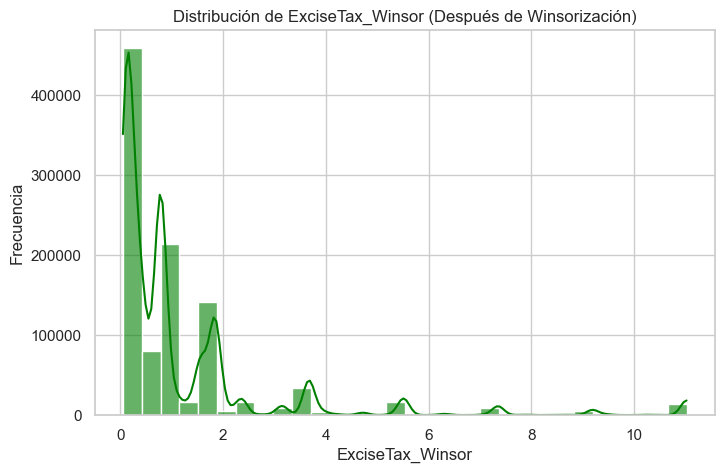

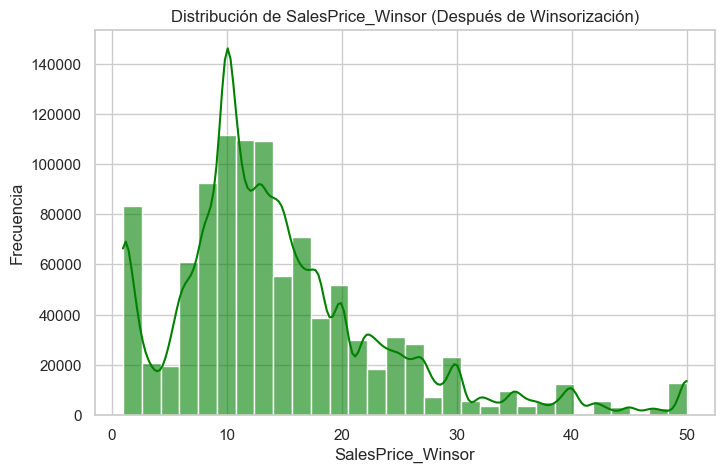

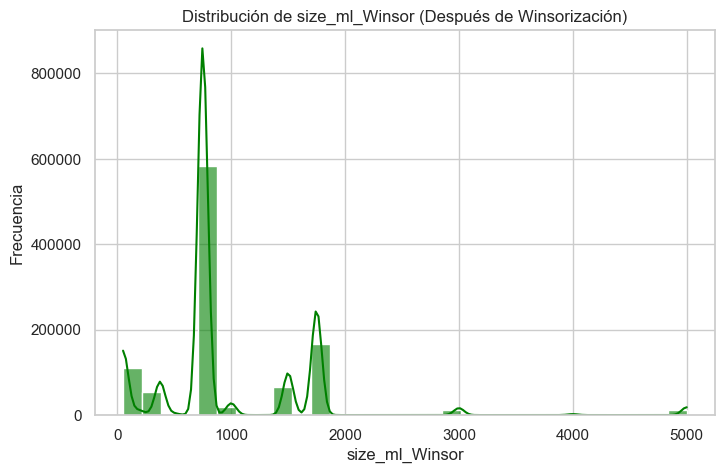

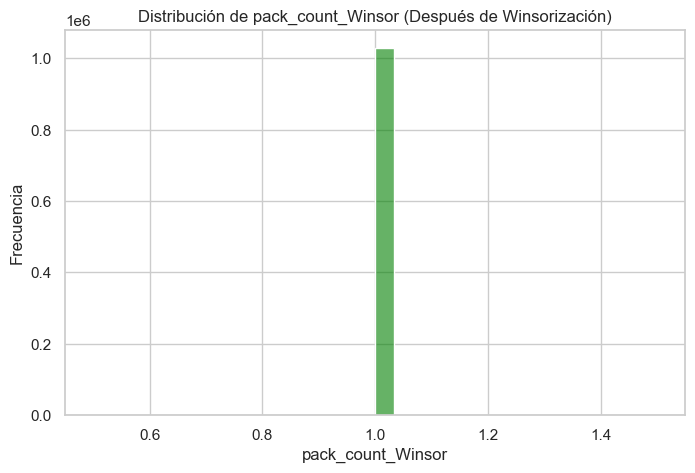

In [25]:
from scipy.stats.mstats import winsorize

# Crear copias de las variables para aplicar winsorización
data_ventas['ExciseTax_Winsor'] = winsorize(data_ventas['ExciseTax'], limits=[0.01, 0.01])
data_ventas['SalesPrice_Winsor'] = winsorize(data_ventas['SalesPrice'], limits=[0.01, 0.01])
data_ventas['size_ml_Winsor'] = winsorize(data_ventas['size_ml'], limits=[0.01, 0.01])
data_ventas['pack_count_Winsor'] = winsorize(data_ventas['pack_count'], limits=[0.01, 0.01])

# Verificar las distribuciones ajustadas
variables_winsor = ['ExciseTax_Winsor', 'SalesPrice_Winsor', 'size_ml_Winsor', 'pack_count_Winsor']
for var in variables_winsor:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_ventas[var], bins=30, kde=True, color='green', alpha=0.6)
    plt.title(f'Distribución de {var} (Después de Winsorización)')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()


Recalcular la Variable de Categoría para Brand


In [26]:
# Recalcular los percentiles con la variable ajustada
percentil_33 = data_ventas['SalesPrice_Winsor'].quantile(0.33)
percentil_67 = data_ventas['SalesPrice_Winsor'].quantile(0.67)

# Reasignar categorías basadas en los nuevos percentiles
def asignar_categoria(precio):
    if precio <= percentil_33:
        return 'Low'
    elif precio <= percentil_67:
        return 'Medium'
    else:
        return 'Top'

# Asignar y codificar categorías
data_ventas['BrandCategory'] = data_ventas['SalesPrice_Winsor'].apply(asignar_categoria)
data_ventas['BrandCategory_encoded'] = data_ventas['BrandCategory'].map({'Low': 0, 'Medium': 1, 'Top': 2})


c:\BaseDeDatosFinal\GestionInventario2016\GABY\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\BaseDeDatosFinal\GestionInventario2016\GABY\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


RMSE: 0.5372804269387867
R² Score: 0.9360225545601947


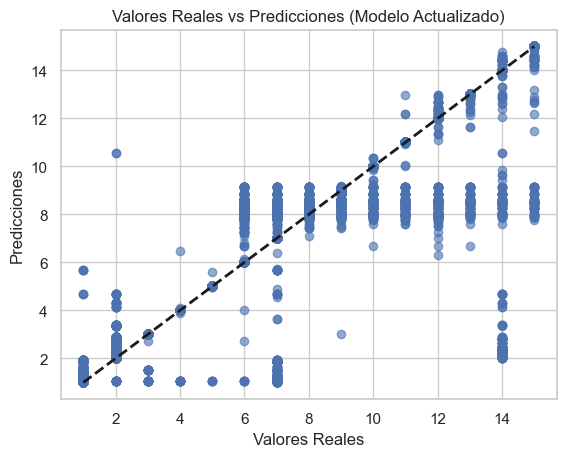

In [27]:
# Características ajustadas
features = ['SalesPrice_Winsor', 'size_ml_Winsor', 'pack_count_Winsor', 'ExciseTax_Winsor', 'BrandCategory_encoded']
target = 'SalesQuantity'

X = data_ventas[features]
y = data_ventas[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predecir y evaluar
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Visualizar los resultados
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('Valores Reales vs Predicciones (Modelo Actualizado)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


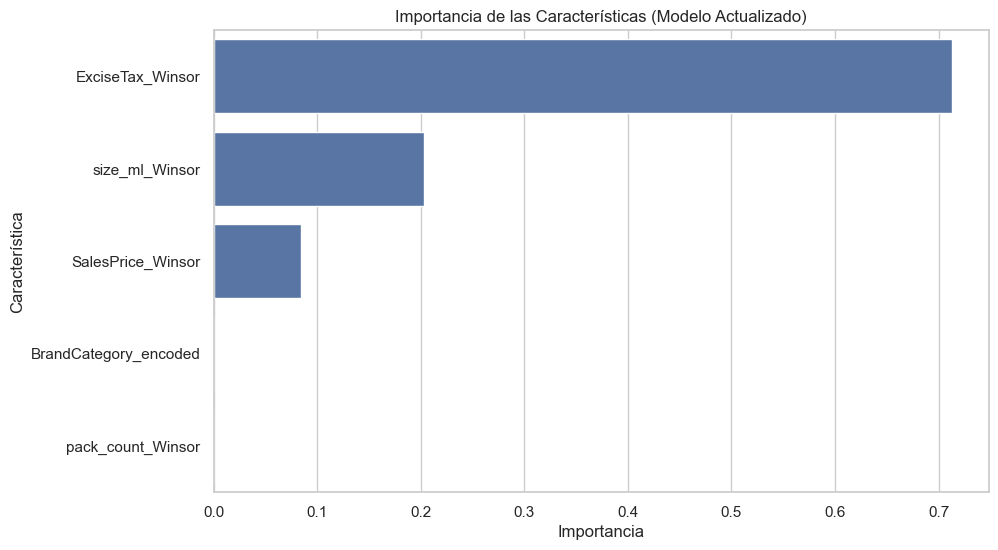

In [28]:
# Importancia de características
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Característica': features, 'Importancia': importances})
feature_importance = feature_importance.sort_values('Importancia', ascending=False)

# Gráfica de importancia
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importancia', y='Característica')
plt.title('Importancia de las Características (Modelo Actualizado)')
plt.show()


In [32]:
# Crear nuevas variables derivadas
data_ventas['ExciseTax_to_SalesPrice'] = data_ventas['ExciseTax_Winsor'] / data_ventas['SalesPrice_Winsor']
data_ventas['size_per_pack'] = data_ventas['size_ml_Winsor'] / data_ventas['pack_count_Winsor']
data_ventas['Revenue_per_size'] = data_ventas['SalesDollars'] / data_ventas['size_ml_Winsor']

# Verificar si las columnas se han creado correctamente
print(data_ventas[['ExciseTax_to_SalesPrice', 'size_per_pack', 'Revenue_per_size']].head())


   ExciseTax_to_SalesPrice  size_per_pack  Revenue_per_size
0                 0.098874          750.0          0.010653
1                 0.098874          750.0          0.010653
2                 0.295369          750.0          0.031960
3                 0.196496          750.0          0.021307
4                 0.098874          750.0          0.010653


In [33]:
# Definir las características y el target
features = [
    'SalesPrice_Winsor',
    'size_ml_Winsor',
    'pack_count_Winsor',
    'ExciseTax_Winsor',
    'ExciseTax_to_SalesPrice',
    'size_per_pack',
    'Revenue_per_size',
    'BrandCategory_encoded'
]
target = 'SalesQuantity'

X = data_ventas[features]
y = data_ventas[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


RMSE: 0.05114017053012917
R² Score: 0.9994203722094813


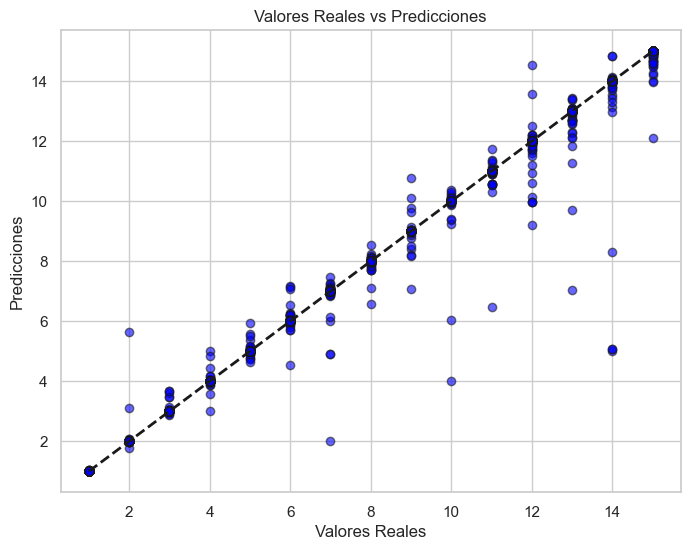

In [34]:
# Visualización de resultados: Valores Reales vs Predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()


grafico de residuales

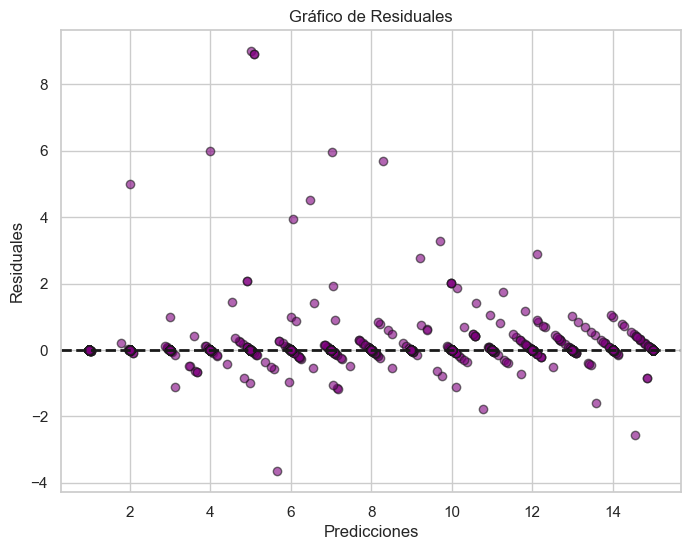

In [35]:
# Cálculo de residuales
residuals = y_test - y_pred

# Gráfico de residuales
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple', edgecolors='k')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.title('Gráfico de Residuales')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()


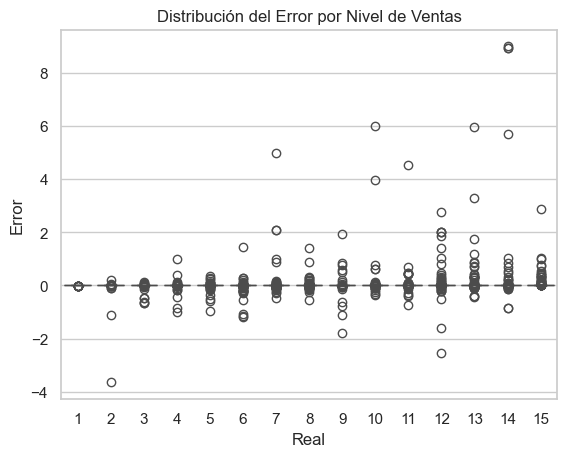

In [42]:
residuals_df = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})
residuals_df['Error'] = residuals_df['Real'] - residuals_df['Predicción']
sns.boxplot(data=residuals_df, x='Real', y='Error')
plt.title('Distribución del Error por Nivel de Ventas')
plt.show()


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_9516\77781916.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


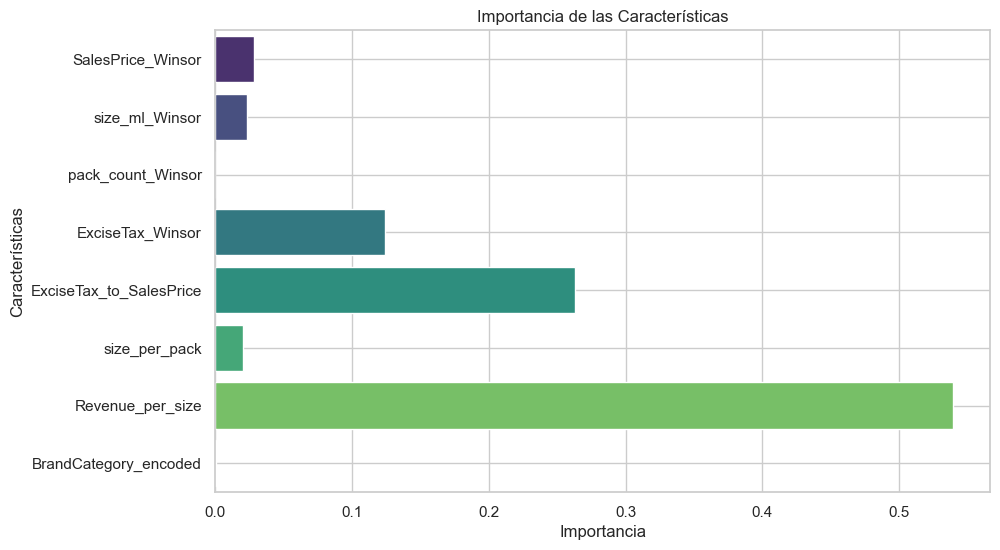

In [37]:
# Importancia de características
importances = rf_model.feature_importances_
features = X_test.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.grid(True)
plt.show()


voy a intentar incluir onhand

In [44]:
# Predecir las ventas usando el modelo entrenado
data_ventas['Predicted_Sales'] = rf_model.predict(X)


para preveer que el onhand inicial es suficiente para cubrir futuras demandas

In [49]:
# Verificar si las columnas necesarias están en ciudades_inventario
if 'onHand_Inicial' in ciudades_inventario.columns and 'onHand_Final' in ciudades_inventario.columns and 'City' in ciudades_inventario.columns:
    # Seleccionar las columnas necesarias de ciudades_inventario
    columnas_adicionales = ciudades_inventario[['InventoryId', 'onHand_Inicial', 'onHand_Final', 'City']]
    
    # Combinar con data_ventas para añadir las columnas directamente
    data_ventas = data_ventas.merge(columnas_adicionales, on='InventoryId', how='left')
    
    print("Columnas 'onHand_Inicial', 'onHand_Final' y 'City' añadidas a data_ventas.")
else:
    print("Error: Las columnas necesarias no están en ciudades_inventario.")

# Verificar el resultado
print(data_ventas.head())

# Guardar data_ventas actualizada si es necesario
data_ventas.to_csv('data_ventas_actualizado.csv', index=False)


Columnas 'onHand_Inicial', 'onHand_Final' y 'City' añadidas a data_ventas.
         InventoryId  Store  Brand            Description  SalesQuantity  \
0  38_goulcrest_8823     38   8823  Leroux Apricot Brandy              1   
1  38_goulcrest_8823     38   8823  Leroux Apricot Brandy              1   
2  38_goulcrest_8823     38   8823  Leroux Apricot Brandy              3   
3  38_goulcrest_8823     38   8823  Leroux Apricot Brandy              2   
4  38_goulcrest_8823     38   8823  Leroux Apricot Brandy              1   

   SalesDollars  SalesPrice   SalesDate  ExciseTax  VendorNumber  ...  \
0          7.99        7.99  2016-01-12       0.79         12546  ...   
1          7.99        7.99  2016-01-14       0.79         12546  ...   
2         23.97        7.99  2016-01-22       2.36         12546  ...   
3         15.98        7.99  2016-01-24       1.57         12546  ...   
4          7.99        7.99  2016-01-25       0.79         12546  ...   

   SalesPrice_Winsor  size_ml

In [50]:
data_ventas.shape

(1027938, 30)

Random forest con info del inventario inicial, no agarro el de final pq es de diciembre

RMSE: 0.0515885461706164
R² Score: 0.9994101637847982


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_9516\2829072153.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='orange')


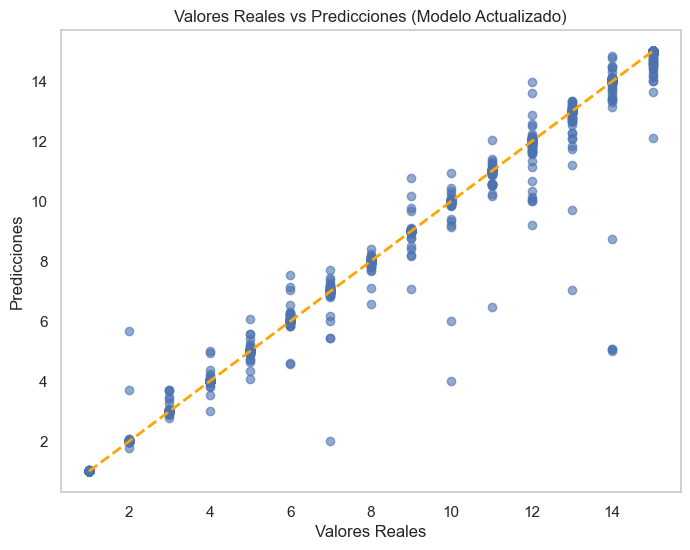

In [52]:
# Definir las características y el target
features = [
    'SalesPrice_Winsor',
    'size_ml_Winsor',
    'pack_count_Winsor',
    'ExciseTax_Winsor',
    'ExciseTax_to_SalesPrice',
    'size_per_pack',
    'Revenue_per_size',
    'BrandCategory_encoded',
    'onHand_Inicial'  # Incorporamos la nueva columna
]
target = 'SalesQuantity'

# Preparar las variables independientes (X) y dependientes (y)
X = data_ventas[features]
y = data_ventas[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Guardar las predicciones en el DataFrame original
data_ventas['Predicted_Sales'] = rf_model.predict(X)

# Visualización: Valores Reales vs Predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='orange')
plt.title('Valores Reales vs Predicciones (Modelo Actualizado)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid()
plt.show()


Alertas de Inventario:
              InventoryId  onHand_Inicial  Predicted_Sales  SalesPrice_Winsor  \
62      38_goulcrest_8892             9.0            14.02              26.99   
112     38_goulcrest_8929             4.0            12.00              12.99   
116     38_goulcrest_8929             4.0             8.00              12.99   
117     38_goulcrest_8929             4.0             5.00              12.99   
935    39_easthallow_1394             0.0             1.00              16.49   
936    39_easthallow_1394             0.0             1.00              16.49   
1108  39_easthallow_14818             0.0             1.00              15.99   
1109  39_easthallow_14818             0.0             1.00              15.99   
1110  39_easthallow_14818             0.0             1.00              15.99   
1128  39_easthallow_15094             8.0            12.00              13.99   

            City  Brand  
62     goulcrest   8892  
112    goulcrest   8929  
116    

C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_9516\1632137938.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=inventory_alerts, x='City', order=inventory_alerts['City'].value_counts().index, palette='viridis')


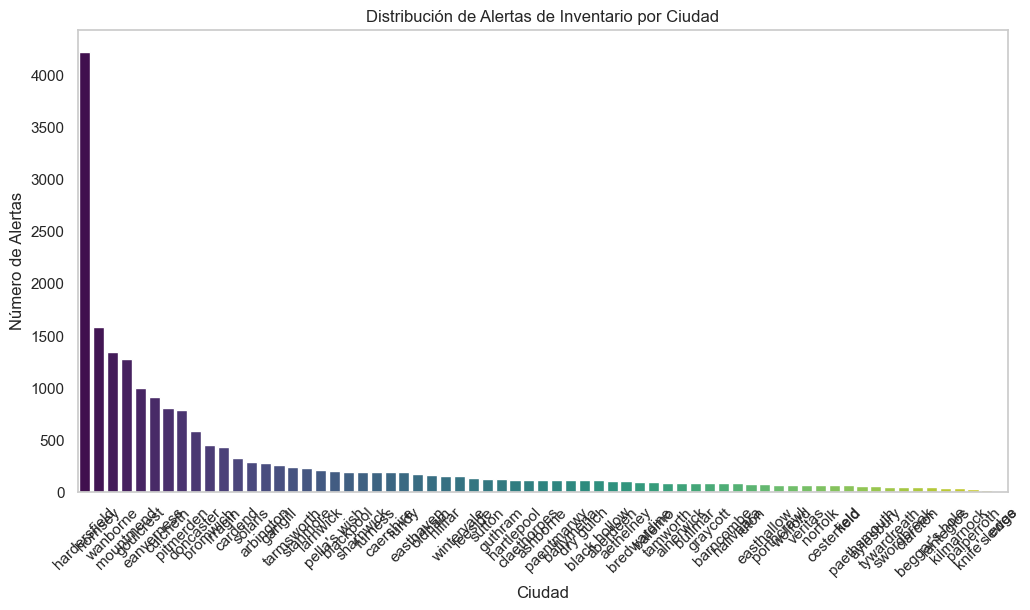

In [53]:
# Crear una columna de alerta basada en la comparación de las ventas predichas y el inventario inicial
data_ventas['Inventory_Alert'] = data_ventas['onHand_Inicial'] < data_ventas['Predicted_Sales']

# Crear una tabla de alertas para análisis
inventory_alerts = data_ventas[data_ventas['Inventory_Alert']][
    ['InventoryId', 'onHand_Inicial', 'Predicted_Sales', 'SalesPrice_Winsor', 'City', 'Brand']
]

# Mostrar las primeras alertas
print("Alertas de Inventario:")
print(inventory_alerts.head(10))

# Guardar la tabla de alertas en un archivo CSV (opcional)
inventory_alerts.to_csv('inventory_alerts.csv', index=False)

# Visualizar las alertas por ciudad
plt.figure(figsize=(12, 6))
sns.countplot(data=inventory_alerts, x='City', order=inventory_alerts['City'].value_counts().index, palette='viridis')
plt.title('Distribución de Alertas de Inventario por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de Alertas')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


C:\Users\anagabrielagonzalezp\AppData\Local\Temp\ipykernel_9516\431630663.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


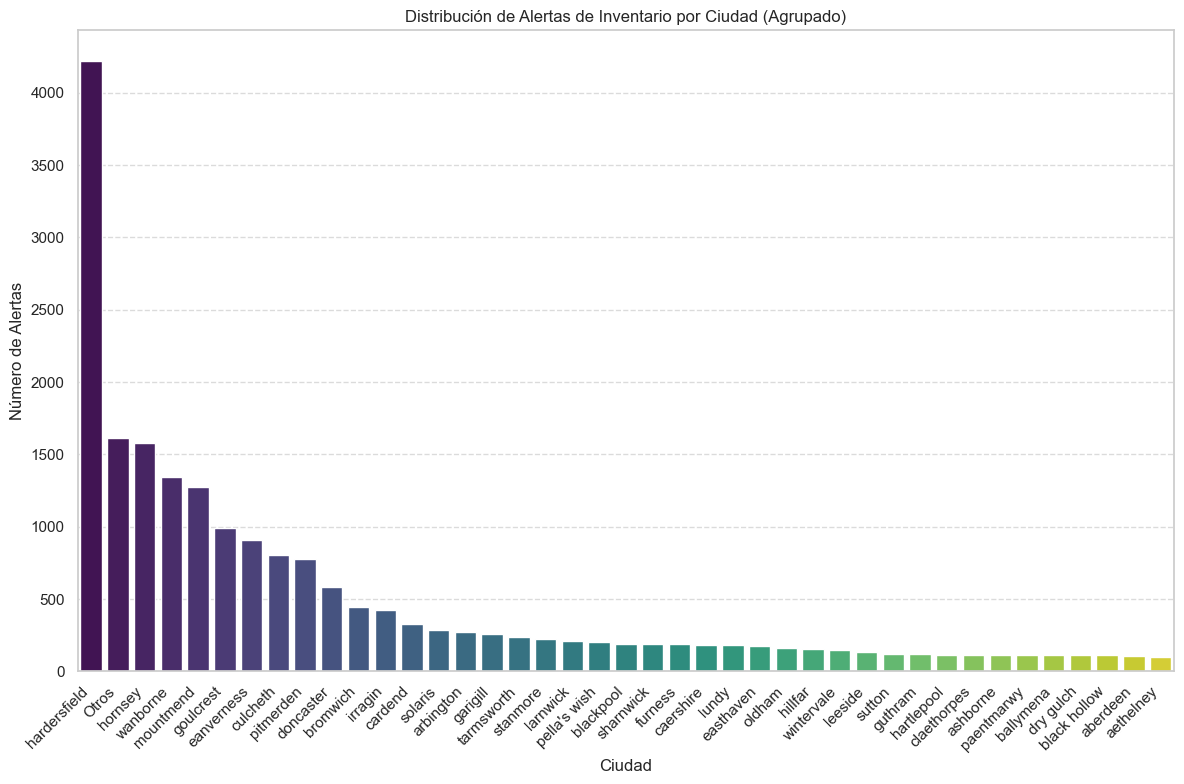

In [54]:
# Crear un umbral para agrupar ciudades menos significativas como 'Otros'
umbral = 100  # Número mínimo de alertas para que una ciudad aparezca individualmente

# Contar alertas por ciudad
alertas_por_ciudad = inventory_alerts['City'].value_counts()

# Reemplazar ciudades con pocas alertas por "Otros"
ciudades_principales = alertas_por_ciudad[alertas_por_ciudad >= umbral].index
inventory_alerts['City_Grouped'] = inventory_alerts['City'].apply(
    lambda x: x if x in ciudades_principales else 'Otros'
)

# Crear un nuevo conteo con las ciudades agrupadas
alertas_por_ciudad_agrupadas = inventory_alerts['City_Grouped'].value_counts()

# Visualización mejorada
plt.figure(figsize=(12, 8))
sns.barplot(
    x=alertas_por_ciudad_agrupadas.index,
    y=alertas_por_ciudad_agrupadas.values,
    palette='viridis'
)
plt.title('Distribución de Alertas de Inventario por Ciudad (Agrupado)')
plt.xlabel('Ciudad')
plt.ylabel('Número de Alertas')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### **Resumen del análisis de alertas:**

1. **Significado del Gráfico:**
   - **Ciudades con más alertas** como `hardersfield`, `wanborne`, y `hornsey` indican posibles desabastecimientos crónicos.
   - Las alertas surgen cuando las **ventas proyectadas** superan el **inventario inicial**.

2. **Implicaciones:**
   - Estas ciudades necesitan ajustes en su planeación de inventarios.
   - La categoría `otros` incluye ciudades con menor frecuencia de alertas, pero que aún deben monitorearse.

3. **Cómo usar este modelo:**
   - **Detección temprana:** Identifica ciudades con riesgo de desabastecimiento.
   - **Optimización:** Mejora la planeación de inventarios al alinear las existencias con las ventas proyectadas.
   - **Reabastecimiento:** Prioriza ciudades con más alertas para minimizar pérdidas.

4. **Recomendaciones rápidas:**
   - Analiza las ciudades críticas (`hardersfield`) para entender los motivos de desabastecimiento.
   - Usa las predicciones del modelo para ajustar inventarios iniciales.
   - Monitorea regularmente las alertas para afinar el sistema de reabastecimiento.



In [56]:
data_ventas.dtypes

InventoryId                 object
Store                        int64
Brand                        int64
Description                 object
SalesQuantity                int64
SalesDollars               float64
SalesPrice                 float64
SalesDate                   object
ExciseTax                  float64
VendorNumber                 int64
size_ml                    float64
pack_count                 float64
SalesID                      int64
BrandCategory               object
BrandCategory_encoded        int64
ExciseTax_Winsorized       float64
SalesPrice_Winsorized      float64
size_ml_Winsorized         float64
pack_count_Winsorized      float64
ExciseTax_Winsor           float64
SalesPrice_Winsor          float64
size_ml_Winsor             float64
pack_count_Winsor          float64
ExciseTax_to_SalesPrice    float64
size_per_pack              float64
Revenue_per_size           float64
Predicted_Sales            float64
onHand_Inicial             float64
onHand_Final        

In [57]:
data_ventas.to_csv('Ventas_Inventarios.csv', index=False)
